In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as sps
from statsmodels.sandbox.stats.multicomp import multipletests
import functools as ft
from functools import partial

# Задание 1
## Определим тип данных в файлах с помощью метрик классификации
Если файл WES то он больше "похож" на референс чем RNA-seq, так как в нем меньше шума и есть участки, которые не экспрессируются.<br>
Формально, проведем классификацию: 1 - ген из файла есть в референсе, 0 - нету.<br>
Будем учитывать случаи, когда в файле есть ген, а в референсе его нет - шум 

* TP - есть в референсе, есть в образце
* FP - нет в референсе, есть в образце
* FN - есть в референсе, нет в образце

$$ Precision = \frac{TP}{TP + FP} $$
$$ Recall = \frac{TP}{TP + FN}$$
$$ F_1 = \frac{Recall \cdot Precision}{Recall + Precision}$$
$$ F_{\beta} = (\beta ^ 2 + 1)\cdot\frac{Recall \cdot Precision}{Recall + \beta^2 \cdot Precision}$$


Так как нам больше важна специфичность (что мы учли все случаи попадания в референс) положим $\beta > 1 \Rightarrow \text{ пусть } \beta = 1.4$

In [2]:
expressions_df = pd.read_csv('/home/marfa/Desktop/Bioinfa/Project_Yudina/archive_1/expressions.tsv', sep = '\t', index_col = 0)
expressions_df.head()

,Sample
Gene,
A1BG,0.768517
A1CF,0.009844
A2M,20.484290
A2ML1,0.344867
A3GALT2,0.515629


In [3]:
qua_75 = np.quantile(expressions_df.Sample, 0.75)
gene_expressed = set(expressions_df[expressions_df.Sample >= qua_75].index.to_list())
len(gene_expressed)

5016

In [4]:
rf_som_muts_df = pd.read_csv('/home/marfa/Desktop/Bioinfa/Project_Yudina/archive_1/reference_set_of_somatic_mutations.tsv', sep = '\t')
ref_mut_prots_hugo = set(rf_som_muts_df.Hugo_Symbol.drop_duplicates().to_list())
rf_som_muts_df.head()

,Hugo_Symbol,Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,Variant_Classification,Variant_Type,t_depth_COLO829_100_A_index1day2,Tumor_VAF_COLO829_100_A_index1day2,...,Tumor_VAF_COLO829_100_B_index1day2,t_depth_COLO829_100_B_index3day2,Tumor_VAF_COLO829_100_B_index3day2,t_depth_filter,Tumor_VAF_median,STDEV,N_vafs,STDEV_filter,N_filter,Reference_filter
0,DFFB,chr1,3865705,3865705,C,T,Intron,SNP,451.0,0.039911,...,0.031250,795.0,0.031447,PASS,0.038126,0.010022,6,PASS,PASS,PASS
1,ACOT7,chr1,6360653,6360653,C,A,Intron,SNP,330.0,0.018182,...,0.023810,523.0,0.017208,PASS,0.017695,0.011690,4,PASS,PASS,PASS
2,UTS2,chr1,7850964,7850964,C,T,Intron,SNP,154.0,0.227273,...,0.289655,245.0,0.302041,PASS,0.223981,0.043102,6,PASS,PASS,PASS
3,MTHFR,chr1,11801075,11801075,G,A,Intron,SNP,107.0,0.168224,...,0.150000,246.0,0.235772,PASS,0.193978,0.031289,6,PASS,PASS,PASS
4,TNFRSF8,chr1,12110171,12110171,C,T,Missense_Mutation,SNP,163.0,0.773006,...,0.798742,272.0,0.738971,PASS,0.782155,0.022271,6,PASS,PASS,PASS


In [12]:
rf_som_muts_df['Variant_Classification'].value_counts()

Missense_Mutation    179
Intron               161
Silent               105
Splice_Region         19
RNA                   17
Nonsense_Mutation     13
3'UTR                 11
3'Flank                8
5'UTR                  7
5'Flank                5
Splice_Site            5
Frame_Shift_Del        4
IGR                    2
Frame_Shift_Ins        1
In_Frame_Del           1
Name: Variant_Classification, dtype: int64

In [6]:
var1_maf = pd.read_csv('/home/marfa/Desktop/Bioinfa/Project_Yudina/archive_1/variants_1.maf',sep = '\t', header=0, comment='#')
var2_maf = pd.read_csv('/home/marfa/Desktop/Bioinfa/Project_Yudina/archive_1/variants_2.maf',sep = '\t', header=0, comment='#')

var1_hugo = set(var1_maf.Hugo_Symbol.drop_duplicates().to_list())
var2_hugo = set(var2_maf.Hugo_Symbol.drop_duplicates().to_list())

print(var1_maf.Hugo_Symbol.drop_duplicates().shape, var2_maf.Hugo_Symbol.drop_duplicates().shape)
var2_maf.head()

(16260,) (4320,)


,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,...,gnomADg_AF_fin,gnomADg_AF_asj,gnomADg_AF_oth,gnomADg_AF_popmax,target_filter,Tumor_VAF,Normal_VAF,VAF_PASS,basic_trash_mutation_filter,LDT_PASS
0,MIR6859-2,0,.,GRCh37,chr1,183180,183180,+,3'Flank,SNP,...,NaN,NaN,NaN,NaN,PASS,0.192982,0.000000,PASS,PASS,PASS
1,SAMD11,0,.,GRCh37,chr1,939180,939180,+,Intron,SNP,...,NaN,NaN,NaN,NaN,NaN,0.093023,0.000000,PASS,PASS,PASS
2,NOC2L,0,.,GRCh37,chr1,948136,948136,+,Silent,SNP,...,NaN,NaN,NaN,NaN,PASS,0.672414,0.000000,PASS,PASS,PASS
3,AGRN,0,.,GRCh37,chr1,1020387,1020387,+,Intron,SNP,...,NaN,NaN,NaN,NaN,NaN,0.097561,0.000000,PASS,PASS,PASS
4,TTLL10,0,.,GRCh37,chr1,1182262,1182262,+,Intron,SNP,...,NaN,NaN,NaN,NaN,NaN,0.727273,0.039216,PASS,PASS,PASS


In [7]:
not_in_ref_hugo_var_1 = var1_hugo - set(ref_mut_prots_hugo)
not_in_ref_hugo_var_2 = var2_hugo - set(ref_mut_prots_hugo)

not_expressed_hugo_var_1 = var1_hugo - set(gene_expressed)
not_expressed_hugo_var_2 = var2_hugo - set(gene_expressed)

print('var1: всего в образце {}, нет в референсе {}, доля {:.3f}'.format(len(var1_hugo), len(not_in_ref_hugo_var_1), len(not_in_ref_hugo_var_1)/len(var1_hugo)))
print('var2: всего в образце {}, нет в референсе {}, доля {:.3f}'.format(len(var2_hugo), len(not_in_ref_hugo_var_2), len(not_in_ref_hugo_var_2)/len(var2_hugo)))
print('\n')
print('var1: всего в образце {}, не экспрессируется {}, доля {:.3f}'.format(len(var1_hugo), len(not_expressed_hugo_var_1), len(not_expressed_hugo_var_1)/len(var1_hugo)))
print('var2: всего в образце {}, не экспрессируется {}, доля {:.3f}'.format(len(var2_hugo), len(not_expressed_hugo_var_2), len(not_expressed_hugo_var_2)/len(var2_hugo)))

var1: всего в образце 16260, нет в референсе 15905, доля 0.978
var2: всего в образце 4320, нет в референсе 3825, доля 0.885


var1: всего в образце 16260, не экспрессируется 11727, доля 0.721
var2: всего в образце 4320, не экспрессируется 3351, доля 0.776


In [8]:
def prec_rec_f1(ref, var, beta = 0, return_tp_fn = False):
    
    TP = len(ref.intersection(var))
    FP = len(var - ref)
    FN = len(ref - var)

    prec = TP / (TP + FP)
    rec = TP / (TP + FN)
    f1 = (rec * prec) / (rec + prec)
    f_b = ''
    if beta:
        f_b = (beta ** 2 + 1) * (rec * prec) / (rec + (beta ** 2) * prec)

    if return_tp_fn:
        return prec, rec, f1, f_b, TP, FN
    
    return prec, rec, f1, f_b


prec, rec, f1, f_b, tp_1, fn_1 = prec_rec_f1(ref_mut_prots_hugo, var1_hugo, 1.4,True)

print('Для первого файла:')
print('Precision:   {:.3f}\nRecall:    {:.3f} \nF_1:  {:.3f} \nF_1.4:    {:.3f}\n'.format(prec, rec, f1, f_b))

prec, rec, f1, f_b, tp_2, fn_2 = prec_rec_f1(ref_mut_prots_hugo, var2_hugo, 1.4, True)
print('Для второго файла:')
print('Precision:   {:.3f}\nRecall:    {:.3f} \nF_1:  {:.3f} \nF_1.4:    {:.3f}'.format(prec, rec, f1, f_b))

Для первого файла:
Precision:   0.022
Recall:    0.696 
F_1:  0.021 
F_1.4:    0.061

Для второго файла:
Precision:   0.115
Recall:    0.971 
F_1:  0.102 
F_1.4:    0.275


Таким образом, первый файл - RNA-seq, второй - WES.

## Данные по экспрессиям
Разделим гены на высоко экспрессируемые и низко экспрессируемые, для этого введем порог, пусть равный 0.75 квантили. <br>
Далее подсчитаем TP и FN для каждого из файлов:

* TP - есть в экспрессии, есть в образце
* FP - нет в экспрессии, есть в образце
* FN - есть в экспрессии, нет в образце

In [13]:
prec, rec, f1, f_b, tp_rna, fn_rna = prec_rec_f1(gene_expressed, var1_hugo, 1.4, True)

print('Для первого файла:')
print('Precision:   {:.3f}\nRecall:    {:.3f} \nF_1:  {:.3f} \nF_1.4:    {:.3f}\n'.format(prec, rec, f1, f_b))

prec, rec, f1, f_b, tp_wes, fn_wes = prec_rec_f1(gene_expressed, var2_hugo, 1.4, True)
print('Для второго файла:')
print('Precision:   {:.3f}\nRecall:    {:.3f} \nF_1:  {:.3f} \nF_1.4:    {:.3f}'.format(prec, rec, f1, f_b))

Для первого файла:
Precision:   0.279
Recall:    0.904 
F_1:  0.213 
F_1.4:    0.514

Для второго файла:
Precision:   0.224
Recall:    0.193 
F_1:  0.104 
F_1.4:    0.203


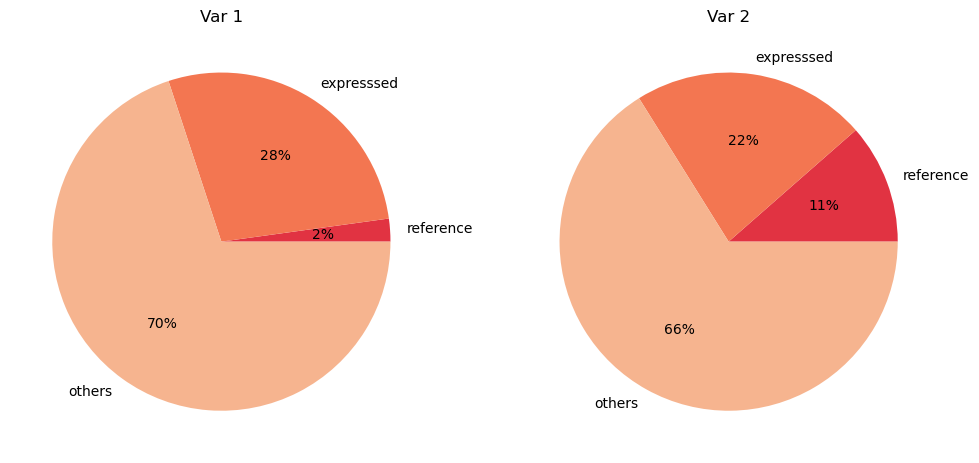

In [14]:
data_rna = [tp_1, tp_rna, len(var1_hugo) - tp_rna- tp_1]
data_wes = [tp_2, tp_wes, len(var2_hugo) - tp_wes- tp_2]
labels = ['reference','expresssed', 'others']

colors_pie = sns.color_palette('rocket')[-3:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.pie(data_rna, labels = labels, colors = colors_pie, autopct='%.0f%%')
ax1.set_title('Var 1')
ax2.pie(data_wes, labels = labels, colors = colors_pie, autopct='%.0f%%')
ax2.set_title('Var 2')
None
# fig.savefig('pie_chart.png')

Видим что в первом файле больше генов, которые экспрессируются, что согласуется с гипотезой, что первый файл RNA-seq. <br>
Рассмотрим распределение экспрессий FN среди первого и второго файлов. Ожидаем, что среди RNAseq файла высоко экспрессируемых генов будет меньше, так как самих генов в файле меньше

медианы экспрессий FN:
var 1: 0.025
var 2: 31.677


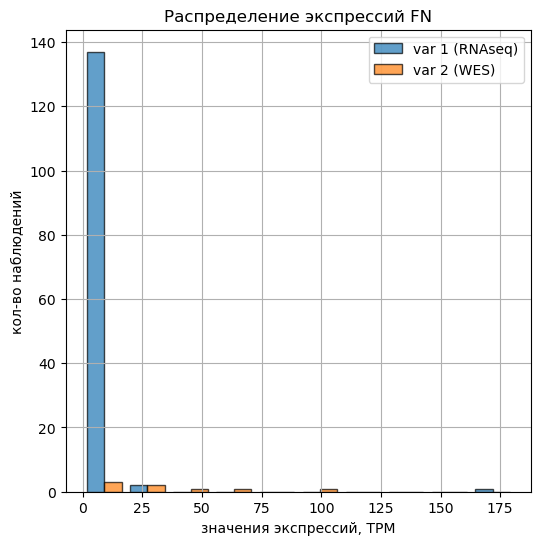

In [15]:
fn1 = ref_mut_prots_hugo- var1_hugo
fn2 = ref_mut_prots_hugo- var2_hugo
fn1_expr = expressions_df.loc[expressions_df.index.isin(fn1),'Sample']
fn2_expr = expressions_df.loc[expressions_df.index.isin(fn2),'Sample']

plt.figure(figsize=(6,6))
plt.hist([fn1_expr, fn2_expr],
          edgecolor='k',
         label=['var 1 (RNAseq)', 'var 2 (WES)'], alpha = 0.7)
plt.legend()
plt.title('Распределение экспрессий FN')
plt.xlabel('значения экспрессий, TPM')
plt.ylabel('кол-во наблюдений')
plt.grid()
print(f'медианы экспрессий FN:\nvar 1: {np.median(fn1_expr):.3f}\nvar 2: {np.median(fn2_expr):.3f}')

In [79]:
# # заккоментировано, так как не являются весомыми выводами для задачи определения файлов

# def filtering(var_df, not_in_ref_hugo, pad_rna = 'MIR', t_vaf_flag = True):
#     var_df = var_df[var_df.Hugo_Symbol.isin(not_in_ref_hugo) &  ~var_df.Hugo_Symbol.isin(['Unknown'])]

#     s = var_df.Hugo_Symbol.str.split('[0-9]{1}')
#     mir_filt = s[s.str[0] == pad_rna].index
#     var_df = var_df[~var_df.index.isin(mir_filt)]

#     if t_vaf_flag:
#         var_df['Tumor_VAF'] = var_df['t_alt_count']/var_df['t_depth']
#         var_df['Tumor_VAF'] = var_df['Tumor_VAF']/sum(var_df['Tumor_VAF'])
    
#     return var_df

In [80]:
# # заккоментировано, так как не являются весомыми выводами для задачи определения файлов

# var1_maf_not_in_ref = filtering(var1_maf, not_in_ref_hugo_var_1)
# var2_maf_not_in_ref = filtering(var2_maf, not_in_ref_hugo_var_2)

# print(f'Размеры файлов после фильтрации \nvar 1 (RNAseq): {var1_maf_not_in_ref.shape[0]},\nvar 2 (WES): {var2_maf_not_in_ref.shape[0]}')

# color0 = sns.color_palette('coolwarm')[-2:]
# plt.figure(figsize = (10,7))
# plt.hist([var1_maf_not_in_ref['Tumor_VAF'],var2_maf_not_in_ref['Tumor_VAF']], 
#          bins = 30, 
#          edgecolor='k', alpha = 0.7,
#          label=['var 1 (RNAseq)','var 2 (WES)'])
# plt.legend(loc='upper right')
# plt.title('Распределение Tumor VAF для генов не попавших в референс')
# plt.show()

# print(f'медианы Tumor VAF:\nvar 1: {np.median(var1_maf_not_in_ref["Tumor_VAF"]):.2e}\nvar 2: {np.median(var2_maf_not_in_ref["Tumor_VAF"]):.2e}')

# print(var1_maf_not_in_ref['dbSNP_RS'].value_counts().head(3),'\n\n', var2_maf_not_in_ref['dbSNP_RS'].value_counts().head(3))

# Варианты, которые не были в референсе, в большинстве своем являются новыми

----

# Задание 2


<font color='#083e86'>$$ \text{VAF} = \frac{{depth\_alt}}{{depth\_alt} + {depth\_{norm}}}$$</font>

*100% purity == 100% Tumor*<br>
На практике обычно наблюдается 20-50% purity <br>

In [19]:
local_dir = '/home/marfa/Desktop/Bioinfa/Project_Yudina/archive_2'

purity = [10,20,30,50,75,100]
purity_num = ['VAF_' + str(i) for i in purity]
colors = sns.color_palette('coolwarm')[-6:]

colo_pur = ['COLO829_' + str(i) for i in purity]
hcc_pur = ['HCC1143_' + str(i) for i in purity]

colo829_dna_maf = []
colo829_rna_maf = []

hcc_dna_maf = []
hcc_rna_maf = []

for j in range(len(colo_pur)):
    colo829_dna_maf.append(pd.read_csv(local_dir + '/' + colo_pur[j] + '.DNA.maf',sep = '\t', header=0, comment='#'))
    colo829_dna_maf[j]['Tumor_VAF'] = colo829_dna_maf[j]['t_alt_count']/colo829_dna_maf[j]['t_depth']

    colo829_rna_maf.append(pd.read_csv(local_dir + '/' + colo_pur[j] + '.RNA.maf',sep = '\t', header=0, comment='#'))
    colo829_rna_maf[j]['Tumor_VAF'] = colo829_rna_maf[j]['t_alt_count']/colo829_rna_maf[j]['t_depth']

    hcc_dna_maf.append(pd.read_csv(local_dir + '/' + hcc_pur[j] + '.DNA.maf',sep = '\t', header=0, comment='#'))
    hcc_dna_maf[j]['Tumor_VAF'] = hcc_dna_maf[j]['t_alt_count']/hcc_dna_maf[j]['t_depth']

    hcc_rna_maf.append(pd.read_csv(local_dir + '/' + hcc_pur[j] + '.RNA.maf',sep = '\t', header=0, comment='#'))
    hcc_rna_maf[j]['Tumor_VAF'] = hcc_rna_maf[j]['t_alt_count']/hcc_rna_maf[j]['t_depth']


Сначала обработаем данные по линии COLO829

In [20]:
# # заккоментировано, так как не являются весомыми выводами для задачи

# plt.rcParams['axes.grid'] = True

# def histplot_vaf_dna_rna(num, mafs, comm = '', fig_size = None):
#     if not fig_size:
#         fig_size = (num*7, 6)

#     if num > 1:
#         fig,axs = plt.subplots(1, num, sharex=True, sharey=True, figsize = fig_size)
#         for i in range(num):
#             axs[i].hist([el['Tumor_VAF']/el['Tumor_VAF'].sum() for el in mafs[i]],
#                     label=purity,
#                     color=colors)
#             axs[i].set_title('Distribution of Tumor VAF' + comm[i] +'depending on % purity')
#             axs[i].legend(loc='upper right')
#             axs[i].set_xlabel('VAF values')
#             axs[i].set_ylabel('Counts')
#     elif num == 1:
#         plt.figure(figsize=fig_size)
#         plt.hist([el['Tumor_VAF']/el['Tumor_VAF'].sum() for el in mafs],
#             label=purity,
#             color=colors)
#         plt.legend()
#         plt.xlabel('VAF values')
#         plt.ylabel('Counts')
#         plt.title('distribution Tumor VAF' + comm +'depending on % purity')
        
#     plt.show()


# histplot_vaf_dna_rna(2, [colo829_dna_maf, colo829_rna_maf], comm =[' DNA ', ' RNA '])

## Построим пересечения мутаций по WES и RNA
* мутация однозначно определяется своими координатами и аллельными вариантами
* делаем пересечение для учета полиморфизмов
* надо рассмотреть как меняется динамика таких мутаций в зависимости от разведения

In [21]:
columns_cross = ['Chromosome', 'Start_Position', 'End_Position','Tumor_Seq_Allele1', 'Tumor_Seq_Allele2']

def cross_dfs(columns, dfs_dna, dfs_rna, flag_for_plot = False):
    """
    dfs_{rna\dna} - {rna\dna}_maf для каждого разведения

    В rna_dna содержатся таблицы пересеченных rna_maf и dna_maf по мутациям для каждого значения разведения

        for_plot == для построения графика зависимости VAF от purity для каждой из мутаций
    В df_{rna\dna}_for_plot - пересечение rna\dna таблиц из rna_dna по мутациям через все разведения
    То есть размер df_{rna\dna}_for_plot определяется наименьшей таблицей из rna_dna
    """

    rna_dna = []
    for i in range(len(dfs_rna)):
        rna_dna.append(pd.merge(dfs_rna[i], dfs_dna[i], how ='inner', on=columns, suffixes=['_rna', '_dna']))

    if flag_for_plot:
        rna_for_plot, dna_for_plot = [], []
        for i in range(len(rna_dna)):
            rna_for_plot.append(rna_dna[i][columns + ['Tumor_VAF_rna']].reset_index(drop=True))
            dna_for_plot.append(rna_dna[i][columns + ['Tumor_VAF_dna']].reset_index(drop=True))

        df_rna_for_plot = ft.reduce(lambda left, right: pd.merge(left, right, on=columns, how = 'inner'), rna_for_plot)
        df_dna_for_plot = ft.reduce(lambda left, right: pd.merge(left, right, on=columns, how = 'inner'), dna_for_plot)

        df_dna_for_plot.columns, df_rna_for_plot.columns = columns + purity_num, columns + purity_num
        return rna_dna, df_dna_for_plot, df_rna_for_plot
            
    return rna_dna

rna_dna_colo, df_dna_for_plot_colo, df_rna_for_plot_colo = cross_dfs(columns_cross, colo829_dna_maf, colo829_rna_maf, flag_for_plot = True)

print(f'Shapes of merged dfs throw purity: {[el.shape[0] for el in rna_dna_colo]}')
df_rna_for_plot_colo.head()

Shapes of merged dfs throw purity: [50, 92, 111, 142, 189, 198]


,Chromosome,Start_Position,End_Position,Tumor_Seq_Allele1,Tumor_Seq_Allele2,VAF_10,VAF_20,VAF_30,VAF_50,VAF_75,VAF_100
0,chr1,35479047,35479047,G,A,0.069984,0.181955,0.237344,0.457763,0.672297,0.742455
1,chr1,156265990,156265990,G,A,0.108491,0.285151,0.402837,0.518170,0.748641,0.892449
2,chr2,96283686,96283686,G,A,0.076986,0.106037,0.195722,0.274704,0.452927,0.602620
3,chr2,96864037,96864037,G,A,0.093645,0.219451,0.342857,0.441368,0.515971,0.608333
4,chr2,98678421,98678421,G,A,0.202899,0.242105,0.438017,0.455696,0.600962,0.536585


Визуализировать динамику VAF в зависимости от разведения клеточных линий (отдельно для WES, отдельно для РНК - какая особенность разведений мутаций наблюдается в РНК)

In [22]:
alpha_holm = 0.05
alpha_by = 0.1

def find_corr(df_dna_for_plot, df_rna_for_plot, mpg_method = 'fdr_by', alpha_pval = 0.1):
    """
    посмотрим насколько скоррелированы данные VAF и степени разведения
    mpg_method - по умолчанию контролирую FDR, для нее обычно используется alpha = 0.1
    Использую метод Бенджамини Иекутиели так как выборки могут быть связанными
    """

    corrs_pvals_rna, corrs_pvals_dna = [], []
    corrs_coefs_rna, corrs_coefs_dna = [], []

    for i, v in df_rna_for_plot.iterrows():
        y = v[purity_num].to_list()
        
        corrs_pvals_rna.append(sps.pearsonr(purity,y)[1])
        corrs_coefs_rna.append(sps.pearsonr(purity,y)[0])

    for i, v in df_dna_for_plot.iterrows():
        y = v[purity_num].to_list()
        
        corrs_pvals_dna.append(sps.pearsonr(purity, y)[1])
        corrs_coefs_dna.append(sps.pearsonr(purity,y)[0])

    mpg = multipletests(corrs_pvals_rna + corrs_pvals_dna, alpha = alpha_pval, method = mpg_method)[1]
    mpg_corr_rna, mpg_corr_dna  = mpg[:len(corrs_pvals_rna)], mpg[len(corrs_pvals_rna):]

    pvals_dna = pd.DataFrame({'до МПГ': corrs_pvals_dna, 'после МПГ': mpg_corr_dna}, index = np.arange(len(mpg_corr_dna)))
    pvals_rna = pd.DataFrame({'до МПГ': corrs_pvals_rna, 'после МПГ': mpg_corr_rna}, index = np.arange(len(mpg_corr_rna)))

    print(f'Для ДНК, до сравнения с уровнем значимости: {pvals_dna.shape},\t меньше уровня: {pvals_dna[pvals_dna["после МПГ"] < alpha_pval].shape}')
    print(f'Для РНК, до сравнения с уровнем значимости: {pvals_rna.shape},\t меньше уровня: {pvals_rna[pvals_rna["после МПГ"] < alpha_pval].shape}\n')
    
    return mpg_corr_dna, mpg_corr_rna, pvals_dna, pvals_rna, corrs_coefs_dna, corrs_coefs_rna

In [23]:
mpg_corr_dna_colo, mpg_corr_rna_colo, pvals_dna_colo, pvals_rna_colo,corrs_coefs_dna_colo, corrs_coefs_rna_colo  = find_corr(df_dna_for_plot_colo, df_rna_for_plot_colo)

print('p-val для РНК')
pvals_rna_colo[pvals_rna_colo['после МПГ'] < alpha_by].head()


Для ДНК, до сравнения с уровнем значимости: (36, 2),	 меньше уровня: (36, 2)
Для РНК, до сравнения с уровнем значимости: (36, 2),	 меньше уровня: (20, 2)

p-val для РНК


,до МПГ,после МПГ
0,0.000331,0.003402
1,0.000249,0.002726
2,0.000015,0.000690
3,0.002706,0.018940
5,0.000139,0.001832


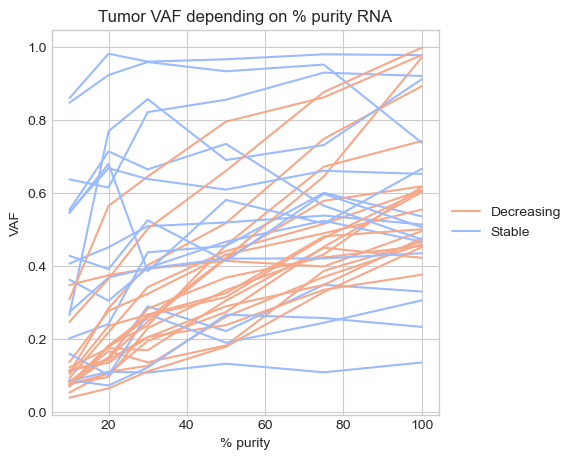

In [24]:
color_maps = lambda pval: 1 if abs(pval) <= alpha_by else 0

def plot_vaf(mpg_corr, res_df, 
            cm = [sns.color_palette('coolwarm')[1], sns.color_palette('coolwarm')[-2]],\
            plot_type = ['Stable', 'Decreasing'], 
            purity = [10,20,30,50,75,100], 
            comm = '', fig_size = (6,6)):
    
    plt.figure(figsize = fig_size)
    plt.style.use('seaborn-whitegrid')
    plt.title('Tumor VAF depending on % purity ' + comm)

    for i, v in res_df.iterrows():
        y = v[purity_num].to_list()
        plt.plot(purity, y, c = cm[color_maps(mpg_corr[i])], label = plot_type[color_maps(mpg_corr[i])])
        
    plt.xlabel('% purity')
    plt.ylabel('VAF')

    handles, labels = plt.gca().get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()


plot_vaf(mpg_corr_rna_colo, df_rna_for_plot_colo, comm = 'RNA', fig_size=(5,5))

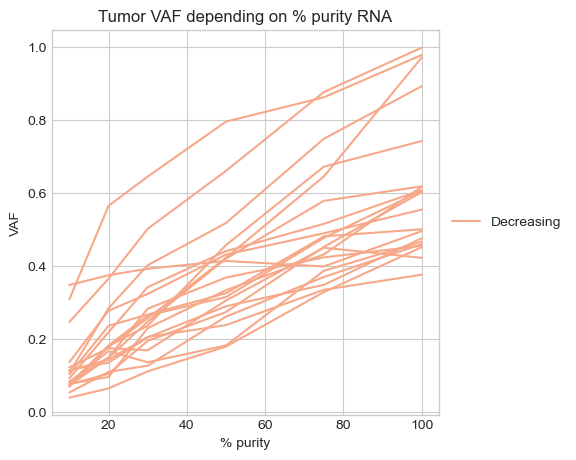

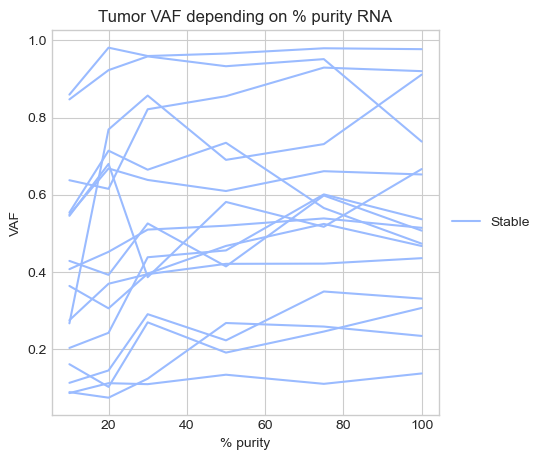

In [25]:
decr_rna_pvals_colo = pvals_rna_colo[pvals_rna_colo['после МПГ'] < alpha_by]['после МПГ']
decr_rna_df_colo = df_rna_for_plot_colo[df_rna_for_plot_colo.index.isin(decr_rna_pvals_colo.index)]

stable_rna_pvals_colo = pvals_rna_colo[pvals_rna_colo['после МПГ'] >= alpha_by]['после МПГ']
stable_rna_df_colo = df_rna_for_plot_colo[df_rna_for_plot_colo.index.isin(stable_rna_pvals_colo.index)]

plot_vaf(decr_rna_pvals_colo.values, decr_rna_df_colo.reset_index(drop = True), comm = 'RNA', fig_size=(5,5))
plot_vaf(stable_rna_pvals_colo.values, stable_rna_df_colo.reset_index(drop = True),comm = 'RNA', fig_size=(5,5))

Рассмотрим нижние 4 линии, это мутации с низкой стабильной экспрессией

In [26]:
index_04_stable_colo = stable_rna_df_colo[stable_rna_df_colo[purity_num]< 0.4].dropna(subset = purity_num).index
rows_04 =pd.merge(colo829_rna_maf[-1], stable_rna_df_colo[stable_rna_df_colo.index.isin(index_04_stable_colo)], how = 'inner', on = columns_cross)
print(*rows_04['Hugo_Symbol'].values)


ALS2 ABCB5 CPB2 PLD3


Визуализируем VAF плоты по ДНК с учетом РНК, среди РНК больше стабильных мутаций

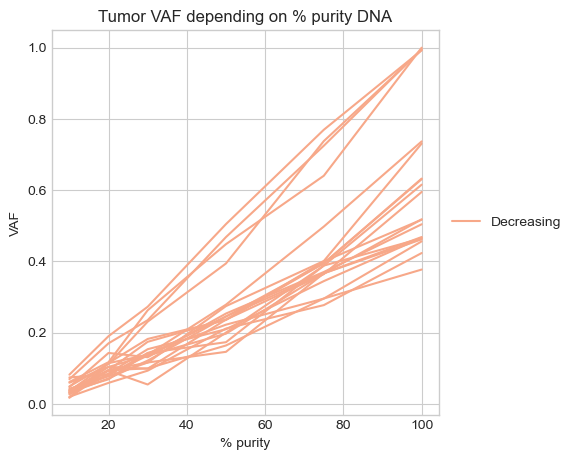

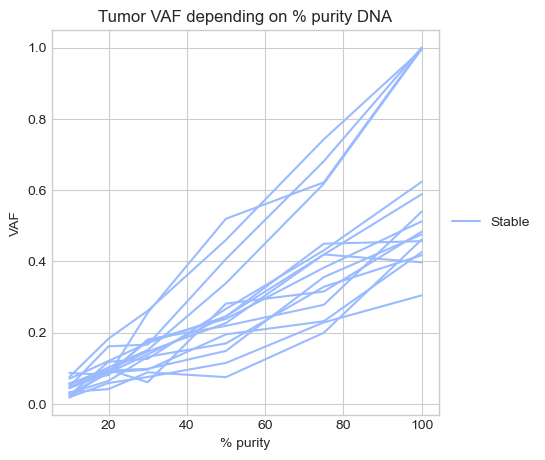

In [27]:
decr_rna_pvals_colo = pvals_rna_colo[pvals_rna_colo['после МПГ'] < alpha_by]['после МПГ']
decr_dna_df_colo = df_dna_for_plot_colo[df_dna_for_plot_colo.index.isin(decr_rna_pvals_colo.index)]

stable_rna_pvals_colo = pvals_rna_colo[pvals_rna_colo['после МПГ'] >= alpha_by]['после МПГ']
stable_dna_df_colo = df_dna_for_plot_colo[df_dna_for_plot_colo.index.isin(stable_rna_pvals_colo.index)]

plot_vaf(decr_rna_pvals_colo.values, decr_dna_df_colo.reset_index(drop = True), comm = 'DNA',fig_size=(5,5))
plot_vaf(stable_rna_pvals_colo.values, stable_dna_df_colo.reset_index(drop = True),comm = 'DNA',fig_size=(5,5))

Как видим стабильные для РНК мутации в ДНК являются спадающими, предположительно эти стабильные мутации являются характеристикой клеточной линии

In [28]:
check_stable_colo = pd.merge(colo829_rna_maf[-1], stable_rna_df_colo, how = 'inner', on = columns_cross)
check_stable_colo.head()

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,...,gnomADg_AN_asj,gnomADg_AN_sas,gnomADg_AN_oth,Tumor_VAF,VAF_10,VAF_20,VAF_30,VAF_50,VAF_75,VAF_100
0,MGAT4A,0,.,GRCh38,chr2,98678421,98678421,+,Nonsense_Mutation,SNP,...,10026.0,30192.0,6074.0,0.536585,0.202899,0.242105,0.438017,0.455696,0.600962,0.536585
1,ALS2,0,.,GRCh38,chr2,201715769,201715769,+,Nonsense_Mutation,SNP,...,NaN,NaN,NaN,0.330798,0.112426,0.144531,0.290441,0.222571,0.349254,0.330798
2,ETV5,0,.,GRCh38,chr3,186048838,186048838,+,Missense_Mutation,SNP,...,NaN,NaN,NaN,0.514277,0.407143,0.452055,0.509682,0.519814,0.538641,0.514277
3,CRACD,0,.,GRCh38,chr4,56315689,56315689,+,Silent,SNP,...,NaN,NaN,NaN,0.467181,0.363636,0.305556,0.395522,0.467337,0.524390,0.467181
4,VCAN,0,.,GRCh38,chr5,83493707,83493707,+,Missense_Mutation,SNP,...,NaN,NaN,NaN,0.977444,0.859649,0.981308,0.959677,0.966102,0.979769,0.977444


In [29]:
stable_hugo_colo = check_stable_colo['Hugo_Symbol'].drop_duplicates().values
print(*stable_hugo_colo, sep = ', ')

MGAT4A, ALS2, ETV5, CRACD, VCAN, ABCB5, PLOD3, MTUS1, MPPED2, TNKS1BP1, CPB2, ARHGAP5, PLD3, TPTE, CECR2, FGD1


BRAF, CDKN2A, PTEN, TERT - мутация в этих генах хартерна для меланомы, у нас таких нет

* MGAT4A (100G>A )- характерен для меланомы <br>
this gene encodes a key glycosyltransferase that regulates the formation of tri- and multiantennary branching structures in the Golgi apparatus. The encoded protein, in addition to the related isoenzyme B, catalyzes the transfer of N-acetylglucosamine (GlcNAc) from UDP-GlcNAc in a beta-1,4 linkage to the Man-alpha-1,3-Man-beta-1,4-GlcNAc arm of R-Man-alpha-1,6(GlcNAc-beta-1,2-Man-alpha-1,3)Man-beta-1,4-GlcNAc-beta-1,4-GlcNAc-beta-1-Asn. The encoded protein may play a role in regulating the availability of serum glycoproteins, oncogenesis, and differentiation. [omim](https://omim.org/entry/604623)
* ALS2 <br>
Alsin, which is encoded by the ALS2 gene, is a member of the guanine nucleotide exchange factors for the small GTPase RAB5 (179512) and plays a role in intracellular endosomal trafficking. Mutations in this gene result in several forms of juvenile lateral sclerosis and infantile-onset ascending spastic paralysis<br>
**Опять что-то связанное с аппаратом Гольджи**<br>
ALS2 participates in hypoxia-induced melanoma cell migration in vitro and lung colonization in vivo [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7749157/)

* ETV5<br>
Is not prognostic in melanoma [protein_atlas](https://www.proteinatlas.org/ENSG00000244405-ETV5/pathology/melanoma)<br>
One [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6161370/) states that ETV5 might serve as useful diagnostic or prognostic factors predicting a more aggressive phenotype in papillary thyroid cancers.

* VCAN <br>
Served as an independent prognostic factor for uveal melanoma. VCAN was positively correlated with metastasis-related pathway, which might imply the metastasis risk of uveal melanoma.[article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8380807/)

* ABCB5 <br>
Is associated with clinical tumor progression, therapeutic resistance and recurrence in cancer patients, including in malignant melanoma [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4119553/)
 
* PLOD3 <br>
Stated in [article](https://www.nature.com/articles/s41419-019-1405-8) about lung cancer: PLOD3 promotes tumor growth

* MTUS1:microtubule associated tumor suppressor 1 <br>
Involved in cell proliferation, migration, and tumor growth. MTUS1 is thought to be downregulated in various human cancers and associated with poor prognosis.[article](https://www.mdpi.com/2075-4418/13/6/1140) 

* TNKS1BP1 <br>
Regulates Actin Cytoskeleton Rearrangement and Cancer Cell Invasion

Загнала транскриптые айди в BioMart с GO

In [30]:
biomart_go_colo = pd.read_csv('/home/marfa/Desktop/Bioinfa/Project_Yudina/biomart_results_colo.tsv', sep = '\t')
biomart_go_colo.head()

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,GO term definition,GO domain,GO term accession,GO term name
0,ENSG00000080618,ENSG00000080618.17,ENST00000181383,ENST00000181383.10,Binding to a zinc ion (Zn).,molecular_function,GO:0008270,zinc ion binding
1,ENSG00000080618,ENSG00000080618.17,ENST00000181383,ENST00000181383.10,The hydrolysis of proteins into smaller polype...,biological_process,GO:0006508,proteolysis
2,ENSG00000080618,ENSG00000080618.17,ENST00000181383,ENST00000181383.10,Catalysis of the hydrolysis of a single C-term...,molecular_function,GO:0004181,metallocarboxypeptidase activity
3,ENSG00000080618,ENSG00000080618.17,ENST00000181383,ENST00000181383.10,A process that solubilizes fibrin in the blood...,biological_process,GO:0042730,fibrinolysis
4,ENSG00000080618,ENSG00000080618.17,ENST00000181383,ENST00000181383.10,The space external to the outermost structure ...,cellular_component,GO:0005576,extracellular region


In [31]:
go_colo = {}

for el in biomart_go_colo['Transcript stable ID'].drop_duplicates():
    go_colo[el] = biomart_go_colo.loc[biomart_go_colo['Transcript stable ID'] == el, 'GO term name'].drop_duplicates().values

go_colo = pd.DataFrame({'func':go_colo.values()}, index = go_colo.keys())

res_func_colo =  []
for val in go_colo['func'].values:
    res_func_colo.extend(val)
res_func_colo = list(set(res_func_colo))

In [32]:
dict_add = {k:[0] for k in res_func_colo}
dict_add = pd.DataFrame(dict_add, index = go_colo.index)
go_func_add = go_colo.join(dict_add)

for transcript_id in tqdm(go_func_add.index):
    values, counts = np.unique(go_func_add.loc[(transcript_id, 'func')], return_counts=True)
    freq = {values[i]:counts[i] for i in range(len(values))}

    for val in freq.keys():
        go_func_add.loc[(transcript_id, val)] = freq[val] 
del go_func_add['func']

go_func_bag_colo = go_func_add.copy()
go_func_bag_colo.loc['total']= np.round(go_func_bag_colo.mean(numeric_only=True, axis=0),2)
go_func_bag_colo = go_func_bag_colo.astype(float)
go_func_bag_colo.tail()

100%|██████████| 16/16 [00:00<00:00, 451.56it/s]


,procollagen-lysine 5-dioxygenase activity,endosomal transport,endosome membrane,cellular response to ionizing radiation,positive regulation of peptidyl-serine phosphorylation,regulation of endosome size,vesicle,cytoskeleton,peptidase activity,axonogenesis,...,nucleolus,GTPase activator activity,extracellular exosome,fibrinolysis,cell adhesion,nucleic acid phosphodiester bond hydrolysis,intracellular organelle,cell death,transferase activity,DNA metabolic process
ENST00000375135,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ENST00000400585,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ENST00000404938,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ENST00000618007,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
total,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.19,0.06,0.06,...,0.06,0.12,0.25,0.06,0.12,0.06,0.06,0.06,0.12,0.06


In [33]:
def highlight_col(x, threshold = 0.2, row = 'total', i_col = 0):
    r = 'background-color: red'
    df1 = pd.DataFrame('',index=x.index, columns=x.columns[i_col:])
    row_left = x.loc[row, x.columns[i_col:]]

    ind = row_left[row_left >= threshold].index.to_list()
    df1.loc[:, ind] = r
    df1 = df1.astype(str)
    return df1 

# with pd.ExcelWriter('/home/marfa/Desktop/Bioinfa/Project_Yudina/biomart_results_parsed_v2.xlsx', engine='xlsxwriter') as writer:
#     go_func_bag_colo.style.apply(partial(highlight_col, threshold = 0.3), axis=None).to_excel(writer)

row_left = go_func_bag_colo.loc['total',:]
except_go = row_left[row_left>= 0.3].index.to_list()
print(*except_go, sep = '\n')

cytosol
nucleus
cytoplasm
Golgi apparatus
plasma membrane
membrane
metal ion binding
protein binding


Мутации происходят в генах отвественных в некоторой степени в клеточной инвазии: мембраны, цитозоль, аппарат Гольджи (почкование нуклеосом сливающихся с мембраной)

### Аналогично обработаем данные другой клеточной линии

In [34]:
# # заккоментировано, так как не являются весомыми выводами для задачи

# histplot_vaf_dna_rna(2, [hcc_dna_maf, hcc_rna_maf], comm =[' DNA ', ' RNA '])

In [35]:
rna_dna_hcc, df_dna_for_plot_hcc, df_rna_for_plot_hcc = cross_dfs(columns_cross, hcc_dna_maf, hcc_rna_maf, flag_for_plot = True)

print(f'Shapes of merged dfs throw purity: {[el.shape[0] for el in rna_dna_hcc]}')
df_rna_for_plot_hcc.head()

Shapes of merged dfs throw purity: [33, 65, 87, 123, 161, 197]


,Chromosome,Start_Position,End_Position,Tumor_Seq_Allele1,Tumor_Seq_Allele2,VAF_10,VAF_20,VAF_30,VAF_50,VAF_75,VAF_100
0,chr1,155283971,155283971,C,T,0.485714,0.279070,0.512821,0.722222,0.538462,0.546512
1,chr1,162333090,162333090,A,T,0.481481,0.206897,0.341463,0.282353,0.363095,0.231156
2,chr1,247156793,247156793,G,C,0.053782,0.068602,0.082994,0.115718,0.175704,0.204380
3,chr2,203439508,203439508,T,C,0.341463,0.241758,0.329412,0.255708,0.303704,0.298276
4,chr2,223991876,223991876,T,A,0.227273,0.337931,0.345048,0.300733,0.324159,0.300488


In [36]:
mpg_corr_dna_hcc, mpg_corr_rna_hcc, pvals_dna_hcc, pvals_rna_hcc,corrs_coefs_dna_hcc, corrs_coefs_rna_hcc  = find_corr(df_dna_for_plot_hcc, df_rna_for_plot_hcc)
print('p-val для PНК')
pvals_rna_hcc[pvals_rna_hcc['после МПГ'] < alpha_by].head()

Для ДНК, до сравнения с уровнем значимости: (23, 2),	 меньше уровня: (23, 2)
Для РНК, до сравнения с уровнем значимости: (23, 2),	 меньше уровня: (13, 2)

p-val для PНК


,до МПГ,после МПГ
2,0.000036,0.002425
5,0.005993,0.035814
8,0.000971,0.009398
10,0.001440,0.011248
11,0.003363,0.021350


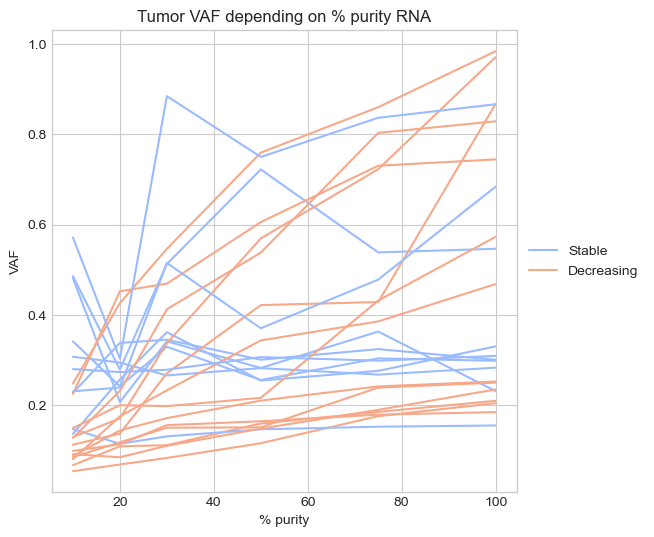

In [37]:
plot_vaf(mpg_corr_rna_hcc, df_rna_for_plot_hcc, comm = 'RNA')

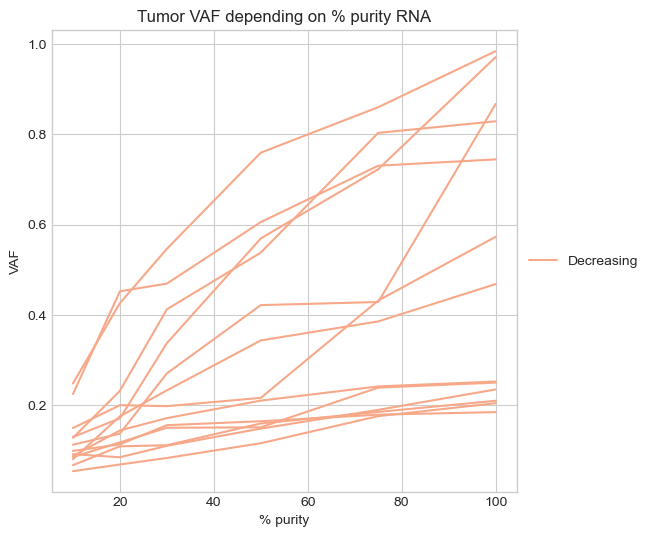

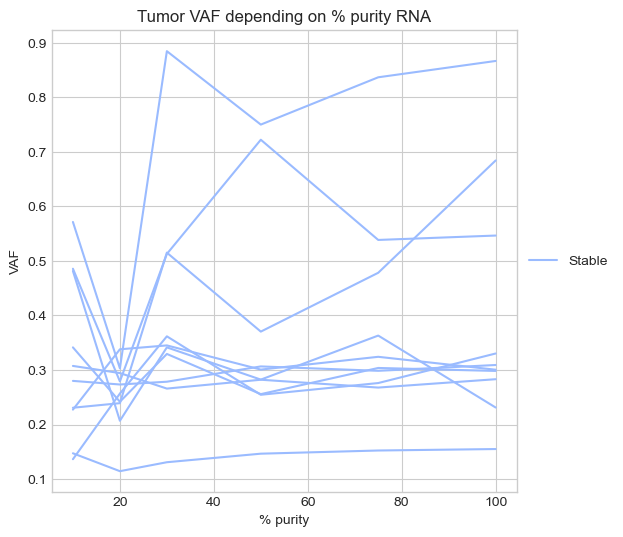

In [38]:
decr_rna_pvals_hcc = pvals_rna_hcc[pvals_rna_hcc['после МПГ'] < alpha_by]['после МПГ']
decr_rna_df_hcc = df_rna_for_plot_hcc[df_rna_for_plot_hcc.index.isin(decr_rna_pvals_hcc.index)]

stable_rna_pvals_hcc = pvals_rna_hcc[pvals_rna_hcc['после МПГ'] >= alpha_by]['после МПГ']
stable_rna_df_hcc = df_rna_for_plot_hcc[df_rna_for_plot_hcc.index.isin(stable_rna_pvals_hcc.index)]

plot_vaf(decr_rna_pvals_hcc.values, decr_rna_df_hcc.reset_index(drop = True), comm = 'RNA')
plot_vaf(stable_rna_pvals_hcc.values, stable_rna_df_hcc.reset_index(drop = True),comm = 'RNA')

In [39]:
index_04_stable_hcc = stable_rna_df_hcc[stable_rna_df_hcc[purity_num]< 0.2].dropna(subset = purity_num).index
rows_04 =pd.merge(hcc_rna_maf[-1], stable_rna_df_hcc[stable_rna_df_hcc.index.isin(index_04_stable_hcc)], how = 'inner', on = columns_cross)
print(*rows_04['Hugo_Symbol'].values)

NET1


Net1 is required for tumor progression in the PyMT mouse model and suggest that Net1 may contribute to breast cancer progression in humans. [article](https://breast-cancer-research.biomedcentral.com/articles/10.1186/s13058-018-0966-2)

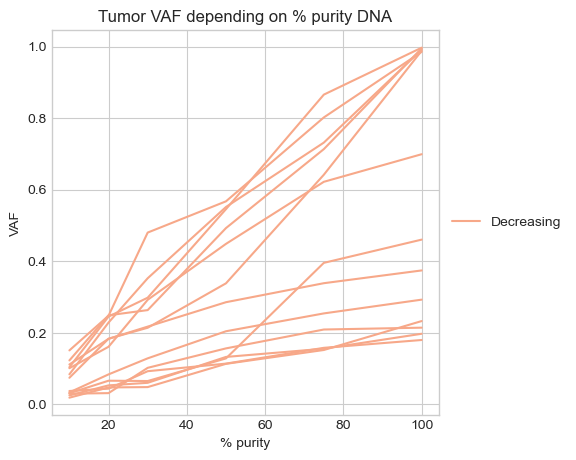

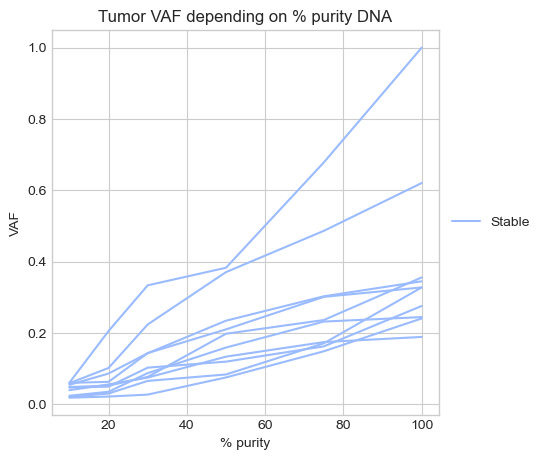

In [40]:
decr_rna_pvals_hcc = pvals_rna_hcc[pvals_rna_hcc['после МПГ'] < alpha_by]['после МПГ']
decr_dna_df_hcc = df_dna_for_plot_hcc[df_dna_for_plot_hcc.index.isin(decr_rna_pvals_hcc.index)]

stable_rna_pvals_hcc = pvals_rna_hcc[pvals_rna_hcc['после МПГ'] >= alpha_by]['после МПГ']
stable_dna_df_hcc = df_dna_for_plot_hcc[df_dna_for_plot_hcc.index.isin(stable_rna_pvals_hcc.index)]

plot_vaf(decr_rna_pvals_hcc.values, decr_dna_df_hcc.reset_index(drop = True), comm = 'DNA',fig_size=(5,5))
plot_vaf(stable_rna_pvals_hcc.values, stable_dna_df_hcc.reset_index(drop = True),comm = 'DNA',fig_size=(5,5))

In [41]:
check_stable_hcc = pd.merge(hcc_dna_maf[-1], stable_rna_df_hcc, how = 'inner', on = columns_cross, suffixes=['_dna','_rna'])
check_stable_hcc = check_stable_hcc[['Hugo_Symbol', 'Transcript_ID'] + columns_cross]
check_stable_hcc

,Hugo_Symbol,Transcript_ID,Chromosome,Start_Position,End_Position,Tumor_Seq_Allele1,Tumor_Seq_Allele2
0,HCN3,ENST00000368358,chr1,155283971,155283971,C,T
1,NOS1AP,ENST00000530878,chr1,162333090,162333090,A,T
2,RAPH1,ENST00000374493,chr2,203439508,203439508,T,C
3,SERPINE2,ENST00000409304,chr2,223991876,223991876,T,A
4,CC2D2A,ENST00000424120,chr4,15574170,15574170,A,T
5,GABRP,ENST00000265294,chr5,170812182,170812182,A,G
6,NET1,ENST00000380359,chr10,5453259,5453259,G,A
7,TLE6,ENST00000246112,chr19,2987216,2987216,G,A
8,HOOK2,ENST00000264827,chr19,12766011,12766011,C,T
9,OPHN1,ENST00000355520,chrX,68234514,68234514,T,C


Для рака груди характерны мутации в генах BRCA1, BRCA2, PTEN, TP53, CDH1, STK11, CHEK2, BRIP1, ATM, PALB2. <br>
У нас, стабильных мутаций в таковых генах нет. <br>
По транскриптам найдем соответствующие идентификаторы генов в BioMart'e, оценим функцию по GO

In [42]:
print(*check_stable_hcc['Hugo_Symbol'].drop_duplicates().to_list(), sep = ', ')

HCN3, NOS1AP, RAPH1, SERPINE2, CC2D2A, GABRP, NET1, TLE6, HOOK2, OPHN1


* HCN3 <br>
Is overexpressed in breast cancer cells compared with normal breast epithelia, and the high expression of HCN3 is associated with poorer survival in breast cancer patients. [article](https://pubmed.ncbi.nlm.nih.gov/34841695/)
* NOS1AP <br>
SCRIB associates with at least two distinct protein complexes, and that an NOS1AP, SCRIB and VANGL1 protein complex modulates the migration, polarity and growth of breast cancer cells. [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3419983/). NOS1AP is not prognostic in breast cancer
* RAPH1 <br>
High RAPH1 expression is correlated with aggressive breast cancer phenotypes and provides independent prognostic value in invasive breast cancer.[article](https://pubmed.ncbi.nlm.nih.gov/30056565/)

* SERPINE2 <br>
Is overexpressed in breast cancer and has been shown to foster metastatic spread [article](https://www.oncotarget.com/article/12927/)

* GABRP <br>
Significant downregulation of GABRP was noted in large primary breast tumours. [article](https://pubmed.ncbi.nlm.nih.gov/16187283/)

* NET1 <br>
Net1 is required for tumor progression in the PyMT mouse model and suggest that Net1 may contribute to breast cancer progression in humans. [article](https://breast-cancer-research.biomedcentral.com/articles/10.1186/s13058-018-0966-2)

* TLE6 <br>
TLE6 is highly expressed in the reproductive system, and its mutation is linked to female infertility 

* HOOK2 <br>
Cytosolic protein, which attach to microtubules [omim](https://omim.org/entry/607824?search=HOOK2&highlight=hook2)

In [43]:
biomart_go_hcc = pd.read_csv('/home/marfa/Desktop/Bioinfa/Project_Yudina/biomart_results_hcc.tsv', sep = '\t')
go_hcc = {}

for el in biomart_go_hcc['Transcript stable ID'].drop_duplicates():
    go_hcc[el] = biomart_go_hcc.loc[biomart_go_hcc['Transcript stable ID'] == el, 'GO term name'].drop_duplicates().values

go_hcc = pd.DataFrame({'func':go_hcc.values()}, index = go_hcc.keys())

res_func_hcc =  []
for val in go_hcc['func'].values:
    res_func_hcc.extend(val)
res_func_hcc = list(set(res_func_hcc))


dict_add = {k:[0] for k in res_func_hcc}
dict_add = pd.DataFrame(dict_add, index = go_hcc.index)
go_func_add = go_hcc.join(dict_add)

for transcript_id in tqdm(go_func_add.index):
    values, counts = np.unique(go_func_add.loc[(transcript_id, 'func')], return_counts=True)
    freq = {values[i]:counts[i] for i in range(len(values))}

    for val in freq.keys():
        go_func_add.loc[(transcript_id, val)] = freq[val] 
del go_func_add['func']

go_func_bag_hcc = go_func_add.copy()
go_func_bag_hcc.loc['total']= np.round(go_func_bag_hcc.mean(numeric_only=True, axis=0),2)
go_func_bag_hcc = go_func_bag_hcc.astype(float)
go_func_bag_hcc.tail()


# with pd.ExcelWriter('/home/marfa/Desktop/Bioinfa/Project_Yudina/biomart_results_parsed_v2_hcc.xlsx', engine='xlsxwriter') as writer:
#     go_func_bag_hcc.style.apply(partial(highlight_col, threshold = 0.3), axis=None).to_excel(writer)

row_left = go_func_bag_hcc.loc['total',:]
except_go = row_left[row_left>= 0.3].index.to_list()
print(*except_go, sep = '\n')


100%|██████████| 10/10 [00:00<00:00, 300.91it/s]

cytosol
cell projection
nucleus
cytoplasm
plasma membrane
signal transduction
synapse
protein binding


Тут больше белков связаны с передачей сигнала, что согласуется с саркомой: рак зарождается в более низких слоях нежели меланома

In [44]:
print(f'Пересечение клеточных линий по стабильным мутациям: {pd.merge(stable_rna_df_colo[columns_cross].reset_index(drop = True), stable_rna_df_hcc[columns_cross].reset_index(drop = True), how ="inner", on=columns_cross, suffixes=["_colo", "_hcc"]).shape[0]}')
print(f'Пересечение клеточных линий по генам мутаций: {pd.merge(check_stable_colo.reset_index(drop = True), check_stable_hcc.reset_index(drop = True), how ="inner", on="Hugo_Symbol", suffixes=["_colo", "_hcc"]).shape[0]}')


Пересечение клеточных линий по стабильным мутациям: 0
Пересечение клеточных линий по генам мутаций: 0


**Таким образом, гипотеза о том, что стабильные мутации являются характеристиками клеточной линии не отвергается**

### Детектирование аллель-специфически экспрессируемых вариантов
Выделим мутации, у которых VAF ДНК (ДНК считаем референсным) $\approx$ 0.5 - гетерозиготы<br>
Для них посмотрим, как сильно меняется VAF РНК в зависимости от разведения, у аллель специфических вариантов VAF не должен быть стабильным. <br>
 Для этого лучше всего использовать t-test, для его использования надо для начала проверить нормальность данных, сделаем это с помощью двух критериев: Шапиро-Уилка и Жарка-Бера

In [45]:
probabl_all_spec_dna_hcc = df_dna_for_plot_hcc[np.isclose(df_dna_for_plot_hcc['VAF_100'], 0.5, rtol = 0.3)][columns_cross + ['VAF_100']].reset_index(drop = True)
probabl_all_spec_dna_colo = df_dna_for_plot_colo[np.isclose(df_dna_for_plot_colo['VAF_100'], 0.5, rtol = 0.3)][columns_cross + ['VAF_100']].reset_index(drop = True)
probabl_all_spec_dna_colo.shape, probabl_all_spec_dna_hcc.shape

((25, 6), (4, 6))

In [46]:
probabl_decr_dna_rna_colo = pd.merge(probabl_all_spec_dna_colo, df_rna_for_plot_colo,how = 'inner', on = columns_cross, suffixes=['_dna', '_rna']).reset_index(drop= True)
probabl_decr_dna_rna_hcc = pd.merge(probabl_all_spec_dna_hcc, df_rna_for_plot_hcc,how = 'inner', on = columns_cross, suffixes=['_dna', '_rna']).reset_index(drop= True)
print(probabl_decr_dna_rna_colo.shape, probabl_decr_dna_rna_hcc.shape)
probabl_decr_dna_rna_colo.head()

(25, 12) (4, 12)


,Chromosome,Start_Position,End_Position,Tumor_Seq_Allele1,Tumor_Seq_Allele2,VAF_100_dna,VAF_10,VAF_20,VAF_30,VAF_50,VAF_75,VAF_100_rna
0,chr2,96283686,96283686,G,A,0.594872,0.076986,0.106037,0.195722,0.274704,0.452927,0.602620
1,chr2,96864037,96864037,G,A,0.630901,0.093645,0.219451,0.342857,0.441368,0.515971,0.608333
2,chr2,98678421,98678421,G,A,0.588764,0.202899,0.242105,0.438017,0.455696,0.600962,0.536585
3,chr2,197402055,197402055,G,A,0.632432,0.078431,0.097166,0.230548,0.334541,0.432258,0.617568
4,chr2,201715769,201715769,G,A,0.623684,0.112426,0.144531,0.290441,0.222571,0.349254,0.330798


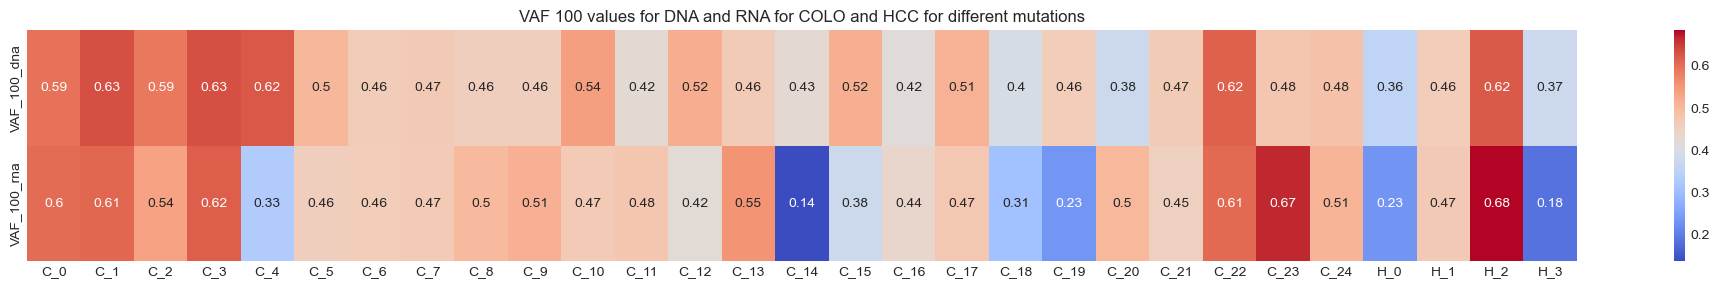

In [47]:
df_for_heat = pd.concat([probabl_decr_dna_rna_colo[['VAF_100_dna', 'VAF_100_rna']], probabl_decr_dna_rna_hcc[['VAF_100_dna', 'VAF_100_rna']]])
df_for_heat.index = ['C_' + str(i) for i in range(probabl_decr_dna_rna_colo.shape[0])] + ['H_'+ str(i) for i in range(probabl_decr_dna_rna_hcc.shape[0])]

xticks = df_for_heat.index

plt.figure(figsize=(25,3))
sns.heatmap(df_for_heat.T,annot = True, cmap = 'coolwarm', linewidth=0, xticklabels=xticks)
plt.title('VAF 100 values for DNA and RNA for COLO and HCC for different mutations')
plt.show()

In [48]:
pval_dna100_jb_colo = sps.jarque_bera(probabl_decr_dna_rna_colo['VAF_100_dna'].values)[1]
pval_rna100_jb_colo = sps.jarque_bera(probabl_decr_dna_rna_colo['VAF_100_rna'].values)[1]

pval_dna100_shap_colo = sps.shapiro(probabl_decr_dna_rna_colo['VAF_100_dna'].values)[1]
pval_rna100_shap_colo = sps.shapiro(probabl_decr_dna_rna_colo['VAF_100_rna'].values)[1]

first_colo = [pval_dna100_jb_colo, pval_rna100_jb_colo, pval_dna100_shap_colo, pval_rna100_shap_colo]
mpg_norm_colo = multipletests(first_colo ,alpha = alpha_by, method = "fdr_by")[1]


check_norm = pd.DataFrame({'p-v до МПГ (Ж-Б)': np.round([pval_dna100_jb_colo,pval_rna100_jb_colo],3),        
    'после МПГ (Ж-Б)': np.round(mpg_norm_colo[:2],3),
             'p-v до МПГ (Ш-У)': np.round([pval_dna100_shap_colo, pval_rna100_shap_colo],3),        
    'после МПГ (Ш-У)': np.round(mpg_norm_colo[2:],3)}, 
    index = ['ДНК', 'РНК'])
check_norm

,p-v до МПГ (Ж-Б),после МПГ (Ж-Б),p-v до МПГ (Ш-У),после МПГ (Ш-У)
ДНК,0.442,0.920,0.066,0.426
РНК,0.153,0.426,0.114,0.426


Гиаотеза о нормальности распределений VAF не отвергается, проведем для них t-test

In [49]:
ttest_pval_100_colo = sps.ttest_rel(probabl_decr_dna_rna_colo.loc[:,'VAF_100_dna'].values, probabl_decr_dna_rna_colo.loc[:,'VAF_100_rna'].values)[1]

ttest_mpg_colo = multipletests(first_colo + [ttest_pval_100_colo],alpha = alpha_by, method = "fdr_by")[1]
ttest_mpg_colo[-1], ttest_pval_100_colo

(0.48818136059528455, 0.1710416445881289)

In [50]:
pval_dna100_jb_hcc = sps.jarque_bera(probabl_decr_dna_rna_hcc['VAF_100_dna'].values)[1]
pval_rna100_jb_hcc = sps.jarque_bera(probabl_decr_dna_rna_hcc['VAF_100_rna'].values)[1]

first_hcc = [pval_dna100_jb_hcc, pval_rna100_jb_hcc]
mpg_norm_hcc = multipletests(first_hcc ,alpha = alpha_by, method = "fdr_by")[1]


check_norm = pd.DataFrame({'p-v до МПГ (Ж-Б)': np.round([pval_dna100_jb_hcc,pval_rna100_jb_hcc],3),        
    'после МПГ (Ж-Б)': np.round(mpg_norm_hcc[:2],3)}, 
    index = ['ДНК', 'РНК'])
check_norm

,p-v до МПГ (Ж-Б),после МПГ (Ж-Б)
ДНК,0.761,1.0
РНК,0.796,1.0


In [51]:
ttest_pval_100_hcc = sps.ttest_rel(probabl_decr_dna_rna_hcc.loc[:,'VAF_100_dna'].values, probabl_decr_dna_rna_hcc.loc[:,'VAF_100_rna'].values)[1]

ttest_mpg_hcc = multipletests(first_hcc + [ttest_pval_100_hcc],alpha = alpha_by, method = "fdr_by")[1]
ttest_mpg_hcc[-1], ttest_pval_100_hcc

(1.0, 0.3751827101267349)

Как видим, гипотеза о одинаковом среднем распределении VAF между РНК и ДНК не отвергается.  <br>
То есть t-test'ом обозначить специфическую экспрессию не удалось

In [52]:
probabl_all_spec_dna_hcc = df_dna_for_plot_hcc[np.isclose(df_dna_for_plot_hcc['VAF_100'], 0.5, rtol = 0.3)][columns_cross + purity_num].reset_index(drop = True)
probabl_all_spec_dna_colo = df_dna_for_plot_colo[np.isclose(df_dna_for_plot_colo['VAF_100'], 0.5, rtol = 0.3)][columns_cross + purity_num].reset_index(drop = True)
probabl_all_spec_dna_colo

,Chromosome,Start_Position,End_Position,Tumor_Seq_Allele1,Tumor_Seq_Allele2,VAF_10,VAF_20,VAF_30,VAF_50,VAF_75,VAF_100
0,chr2,96283686,96283686,G,A,0.059172,0.103896,0.098563,0.236559,0.364211,0.594872
1,chr2,96864037,96864037,G,A,0.030973,0.071429,0.121352,0.244966,0.394309,0.630901
2,chr2,98678421,98678421,G,A,0.028112,0.087659,0.139344,0.246231,0.419298,0.588764
3,chr2,197402055,197402055,G,A,0.038462,0.094474,0.174118,0.236443,0.394799,0.632432
4,chr2,201715769,201715769,G,A,0.024336,0.118547,0.126761,0.266949,0.431151,0.623684
5,chr3,75739122,75739122,G,A,0.047022,0.142857,0.130790,0.253482,0.370149,0.504155
6,chr3,100167788,100167788,G,A,0.042254,0.077449,0.115987,0.145963,0.366477,0.461957
7,chr3,139389615,139389615,C,T,0.032872,0.103448,0.136066,0.245536,0.366548,0.468333
8,chr3,179414995,179414995,G,A,0.035874,0.068841,0.142180,0.222222,0.295455,0.456221
9,chr3,186048838,186048838,T,C,0.070922,0.120915,0.171004,0.245614,0.449848,0.457055


In [53]:
probabl_left_decr_dna_rna_colo = probabl_decr_dna_rna_colo.copy()
probabl_left_decr_dna_rna_colo['diff'] = np.abs(probabl_decr_dna_rna_colo['VAF_100_dna'] - probabl_decr_dna_rna_colo['VAF_100_rna'])
probabl_left_decr_dna_rna_colo = probabl_left_decr_dna_rna_colo[probabl_left_decr_dna_rna_colo['diff'] > 0.15]

probabl_left_decr_dna_rna_hcc = probabl_decr_dna_rna_hcc.copy()
probabl_left_decr_dna_rna_hcc['diff'] = np.abs(probabl_decr_dna_rna_hcc['VAF_100_dna'] - probabl_decr_dna_rna_hcc['VAF_100_rna'])
probabl_left_decr_dna_rna_hcc = probabl_left_decr_dna_rna_hcc[probabl_left_decr_dna_rna_hcc['diff'] > 0.15]

probabl_left_decr_dna_rna_colo

,Chromosome,Start_Position,End_Position,Tumor_Seq_Allele1,Tumor_Seq_Allele2,VAF_100_dna,VAF_10,VAF_20,VAF_30,VAF_50,VAF_75,VAF_100_rna,diff
4,chr2,201715769,201715769,G,A,0.623684,0.112426,0.144531,0.290441,0.222571,0.349254,0.330798,0.292886
14,chr7,20659006,20659006,C,T,0.426160,0.085859,0.111524,0.109005,0.133498,0.109827,0.136732,0.289428
19,chr19,40374523,40374523,C,T,0.461538,0.088339,0.073964,0.123167,0.267544,0.258308,0.234043,0.227496
23,chr22,17539107,17539107,G,A,0.475771,0.545455,0.680000,0.386364,0.581395,0.516949,0.666667,0.190896


In [54]:
print(*pd.merge(colo829_dna_maf[-1], probabl_decr_dna_rna_colo, how = 'inner', on = columns_cross)['Hugo_Symbol'].values, sep = ', ')

SNRNP200, SEMA4C, MGAT4A, SF3B1, ALS2, ZNF717, CMSS1, COPB2, GNB4, ETV5, CRACD, SMARCAD1, SCUBE3, CYTH3, ABCB5, ANLN, PLOD3, MTUS1, CPB2, PLD3, DLGAP4, ZNF217, TMEM50B, CECR2, FGD1


In [55]:
ref_muted_dna_rna_colo = rna_dna_colo[-1]
ref_muted_dna_rna_colo['diff'] = np.abs(ref_muted_dna_rna_colo["Tumor_VAF_dna"] - ref_muted_dna_rna_colo["Tumor_VAF_rna"])
ref_muted_dna_rna_colo = ref_muted_dna_rna_colo[ref_muted_dna_rna_colo['diff'] > 0.15]
ref_muted_dna_rna_colo = ref_muted_dna_rna_colo[np.isclose(ref_muted_dna_rna_colo['Tumor_VAF_dna'], 0.5, rtol = 0.3)]

for_scatter_ref_muted_dna_rna_colo = []
for el in rna_dna_colo[:-1]:
    el_copy = el.copy()
    el_copy = pd.merge(ref_muted_dna_rna_colo[columns_cross], el, how = 'inner', on = columns_cross, suffixes = ['_ref', '_left'])
    for_scatter_ref_muted_dna_rna_colo.append(el_copy)

for_scatter_ref_muted_dna_rna_colo.append(ref_muted_dna_rna_colo)

In [56]:
print(*ref_muted_dna_rna_colo['Hugo_Symbol_rna'].values, sep = ', ')

ATP13A2, GPR161, ALS2, AGFG1, LINC01060, H2AC14, STK19, KIAA0408, RPS12, RPS6KA2, HDAC9, ABCB5, GIGYF1, SLC45A4, ZC3H3, ANKRD18A, TRAF1, NAXD, NLRC3, SLC26A11, ZNF208, PLD3, BAGE2, CECR2, TRIOBP


AP3P1, BCLAF1, STED8, PRIM2, IL32, SEC22, and MAP2K3 

In [57]:
ref_muted_dna_rna_hcc = rna_dna_hcc[-1]
ref_muted_dna_rna_hcc['diff'] = np.abs(ref_muted_dna_rna_hcc["Tumor_VAF_dna"] - ref_muted_dna_rna_hcc["Tumor_VAF_rna"])
ref_muted_dna_rna_hcc = ref_muted_dna_rna_hcc[ref_muted_dna_rna_hcc['diff'] > 0.15]
ref_muted_dna_rna_hcc = ref_muted_dna_rna_hcc[np.isclose(ref_muted_dna_rna_hcc['Tumor_VAF_dna'], 0.5, rtol = 0.3)]

for_scatter_ref_muted_dna_rna_hcc = []
for el in rna_dna_hcc[:-1]:
    el_copy = el.copy()
    el_copy = pd.merge(ref_muted_dna_rna_hcc[columns_cross], el, how = 'inner', on = columns_cross, suffixes = ['_ref', '_left'])
    for_scatter_ref_muted_dna_rna_hcc.append(el_copy)

for_scatter_ref_muted_dna_rna_hcc.append(ref_muted_dna_rna_hcc)

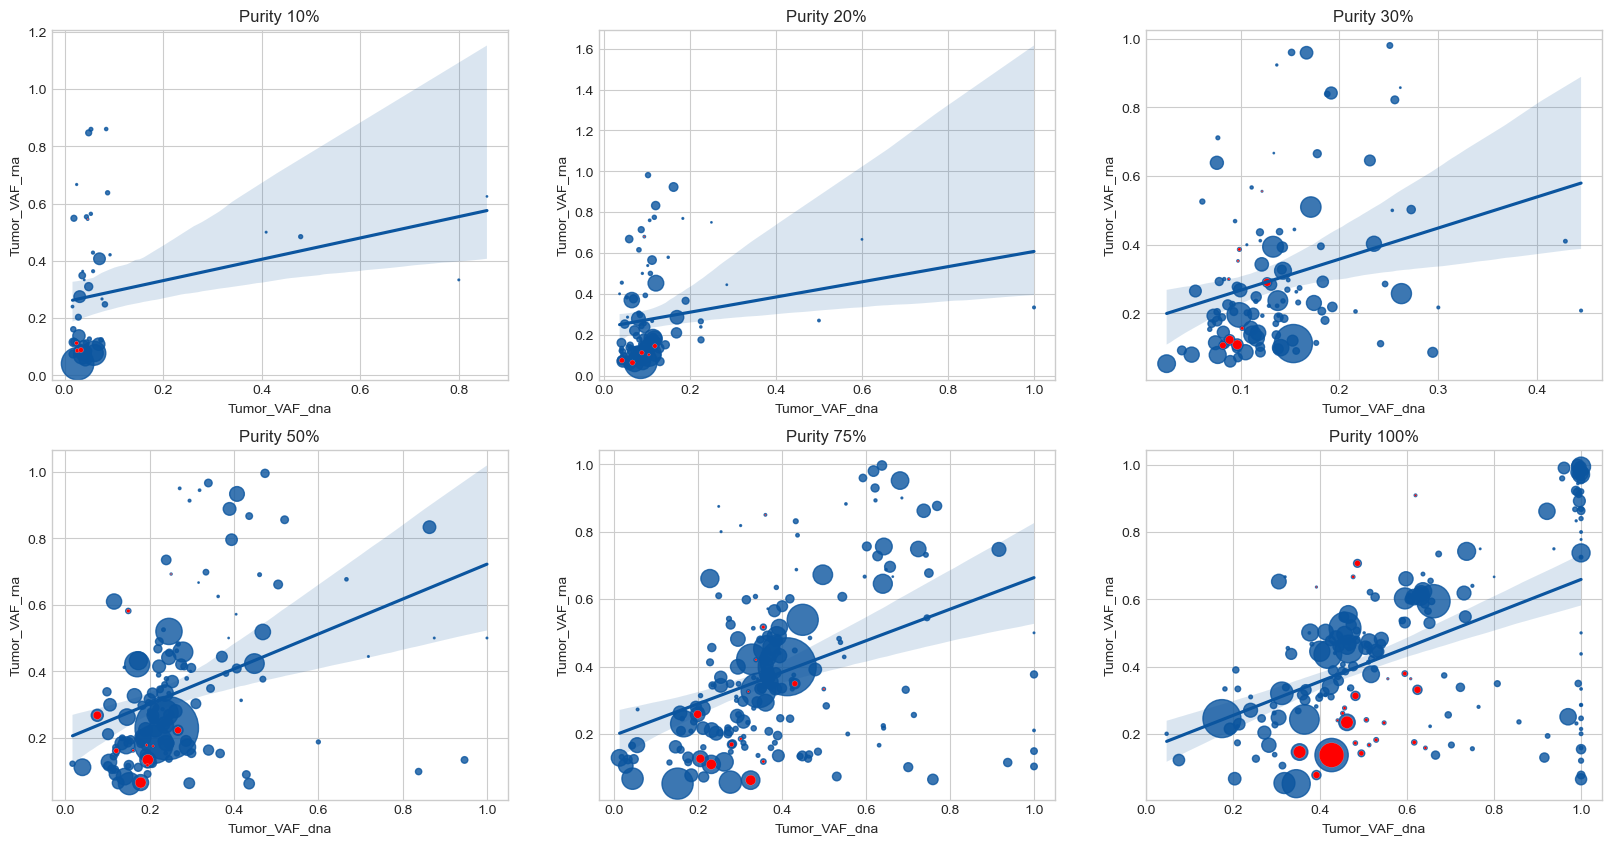

In [58]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
colorii = sns.color_palette("Blues")[-1]
for i, ax_i in enumerate(axs.reshape(-1)):
    sns.regplot(data=rna_dna_colo[i], x="Tumor_VAF_dna", y="Tumor_VAF_rna", ax=ax_i, scatter=True,color = colorii, scatter_kws={'s': rna_dna_colo[i]['t_depth_rna']/rna_dna_colo[i]['t_depth_rna'].min()})
    sns.scatterplot(data = for_scatter_ref_muted_dna_rna_colo[i], x="Tumor_VAF_dna", y="Tumor_VAF_rna", ax=ax_i, color = 'red', s = for_scatter_ref_muted_dna_rna_colo[i]['t_depth_rna']/for_scatter_ref_muted_dna_rna_colo[i]['t_depth_rna'].min())
    ax_i.set_title('Purity ' + str(purity[i]) + '%')

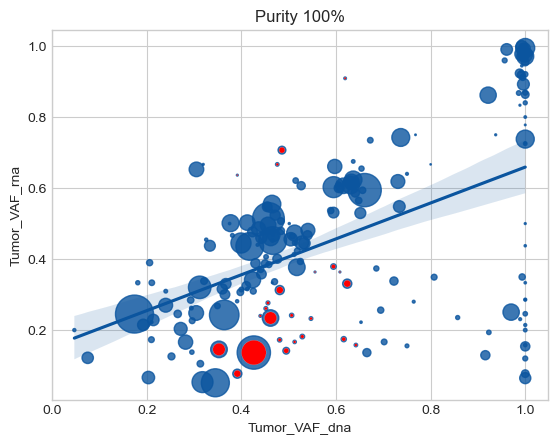

In [59]:
sns.regplot(data=rna_dna_colo[-1], x="Tumor_VAF_dna", y="Tumor_VAF_rna", scatter=True,color = colorii, scatter_kws={'s': rna_dna_colo[-1]['t_depth_rna']/rna_dna_colo[-1]['t_depth_rna'].min()})
sns.scatterplot(data = for_scatter_ref_muted_dna_rna_colo[-1], x="Tumor_VAF_dna", y="Tumor_VAF_rna", color = 'red', s = for_scatter_ref_muted_dna_rna_colo[-1]['t_depth_rna']/for_scatter_ref_muted_dna_rna_colo[-1]['t_depth_rna'].min())
plt.title('Purity 100%')
plt.show()

In [60]:
for_scatter_ref_muted_dna_rna_colo[-1]['Hugo_Symbol_rna'][for_scatter_ref_muted_dna_rna_colo[-1]['Hugo_Symbol_rna'].isin(check_stable_colo['Hugo_Symbol'].drop_duplicates().to_list())]

32      ALS2
80     ABCB5
173     PLD3
188    CECR2
Name: Hugo_Symbol_rna, dtype: object

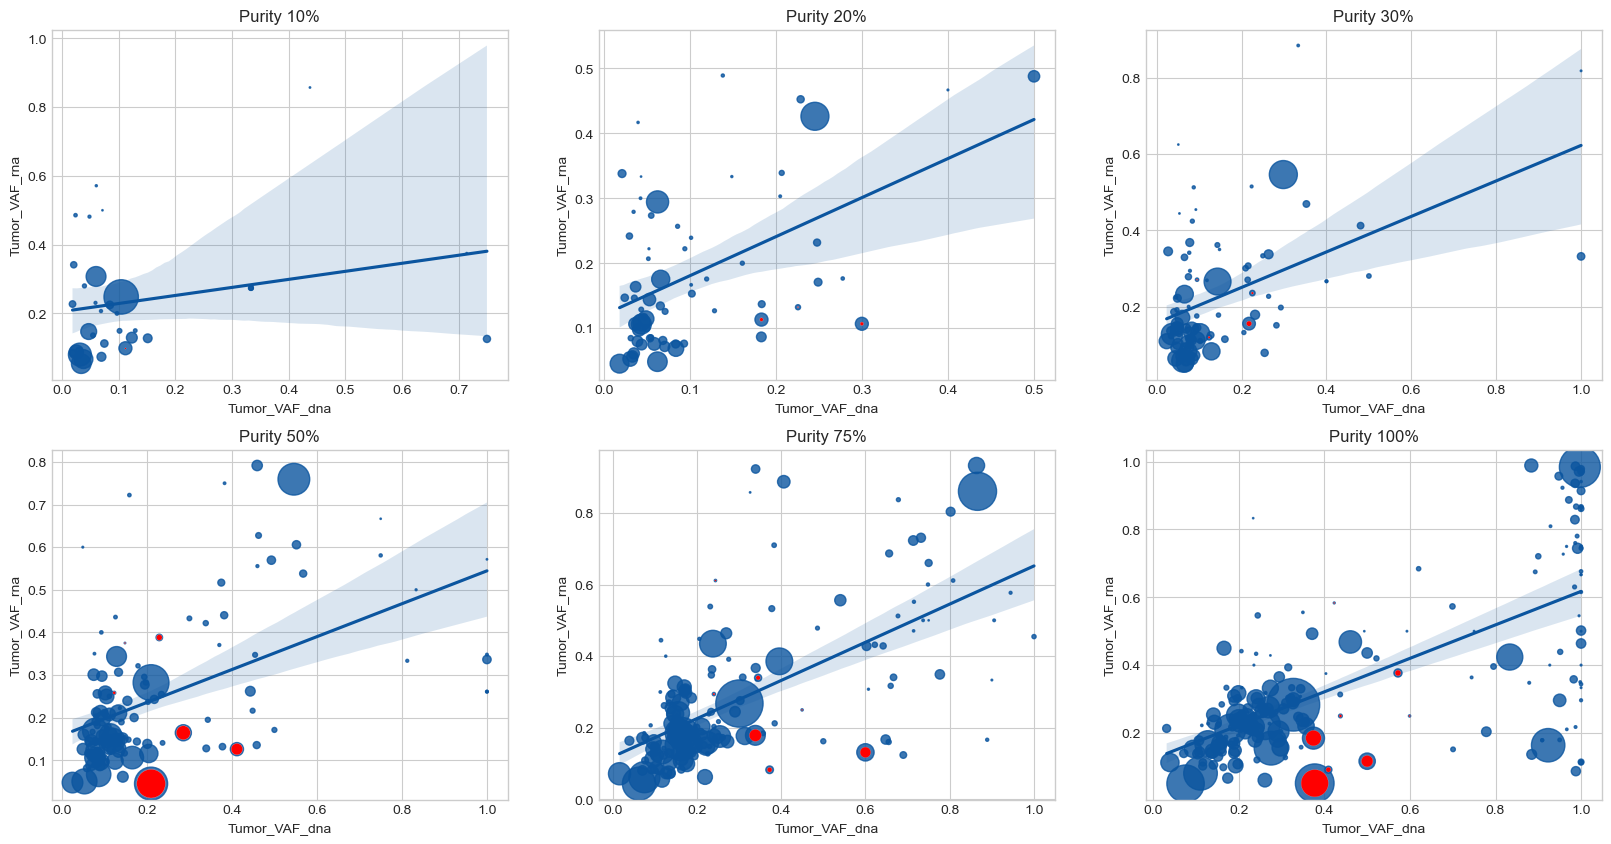

In [61]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
colorii = sns.color_palette("Blues")[-1]
for i, ax_i in enumerate(axs.reshape(-1)):

    rna_dna_hcc[i] = rna_dna_hcc[i].dropna(subset = ['Tumor_VAF_dna', 'Tumor_VAF_rna', 't_depth_rna'])
    
    sns.regplot(data=rna_dna_hcc[i], x="Tumor_VAF_dna", y="Tumor_VAF_rna", ax=ax_i, scatter=True,color = colorii, scatter_kws={'s': rna_dna_hcc[i]['t_depth_rna']/rna_dna_hcc[i]['t_depth_rna'].min()})
    sns.scatterplot(data = for_scatter_ref_muted_dna_rna_hcc[i], x="Tumor_VAF_dna", y="Tumor_VAF_rna", ax=ax_i, color = 'red', s = for_scatter_ref_muted_dna_rna_hcc[i]['t_depth_rna']/for_scatter_ref_muted_dna_rna_hcc[i]['t_depth_rna'].min())
    
    ax_i.set_title('Purity ' + str(purity[i]) + '%')

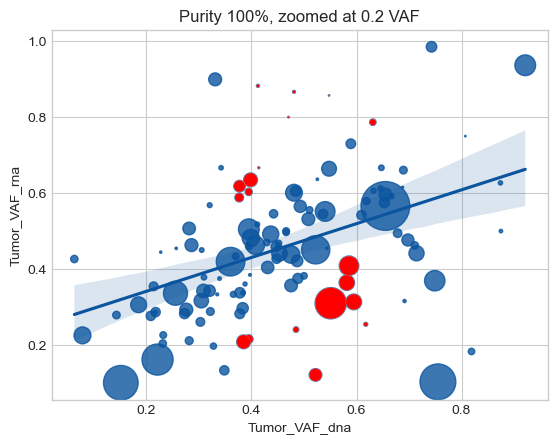

In [62]:
rna_dna_hcc_last = rna_dna_hcc[-1][rna_dna_hcc[-1]['Tumor_VAF_dna'] < 0.5]
rna_dna_hcc_last = rna_dna_hcc_last[rna_dna_hcc_last['Tumor_VAF_rna'] < 0.5]
rna_dna_hcc_last['Tumor_VAF_dna'] = rna_dna_hcc_last['Tumor_VAF_dna']*2
rna_dna_hcc_last['Tumor_VAF_rna'] = rna_dna_hcc_last['Tumor_VAF_rna']*2

ref_muted_dna_rna_hcc_last = rna_dna_hcc_last
ref_muted_dna_rna_hcc_last['diff'] = np.abs(ref_muted_dna_rna_hcc_last["Tumor_VAF_dna"] - ref_muted_dna_rna_hcc_last["Tumor_VAF_rna"])
ref_muted_dna_rna_hcc_last = ref_muted_dna_rna_hcc_last[ref_muted_dna_rna_hcc_last['diff'] > 0.15]
ref_muted_dna_rna_hcc_last = ref_muted_dna_rna_hcc_last[np.isclose(ref_muted_dna_rna_hcc_last['Tumor_VAF_dna'], 0.5, rtol = 0.3)]

sns.regplot(data = rna_dna_hcc_last, x="Tumor_VAF_dna", y="Tumor_VAF_rna", color = colorii, scatter_kws = {'s' : rna_dna_hcc_last['t_depth_rna']/rna_dna_hcc_last['t_depth_rna'].min()})
sns.scatterplot(data = ref_muted_dna_rna_hcc_last, x="Tumor_VAF_dna", y="Tumor_VAF_rna", color = 'red', s = ref_muted_dna_rna_hcc_last['t_depth_rna']/ref_muted_dna_rna_hcc_last['t_depth_rna'].min())
plt.title('Purity 100%, zoomed at 0.2 VAF')
plt.show()

In [63]:
print(*ref_muted_dna_rna_hcc_last['Hugo_Symbol_rna'].values, sep = ', ')

CROCCP2, RASAL2, PTPRC, ZNF124, DZIP1L, WDR41, FOXP4, NET1, CSTF2T, SEMA4G, NUP98, MSI1, EXOC5, PCNX4, MEIS2, NLRC5, CACNG4, ZNF516, PLEKHG2, OPHN1


In [64]:
ref_muted_dna_rna_hcc_last['Hugo_Symbol_rna'][ref_muted_dna_rna_hcc_last['Hugo_Symbol_rna'].isin(check_stable_hcc['Hugo_Symbol'].drop_duplicates().to_list())]

90      NET1
196    OPHN1
Name: Hugo_Symbol_rna, dtype: object